In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import numpy as np

In [26]:
merged_df = pd.read_csv('./zip_summary.csv')

# adding feature for analysis 
merged_df['complaints_per_10k'] = (merged_df['total_complaints'] / merged_df['total_population']) * 10000

merged_df.head()

,incident_zip,total_complaints,AHV Inspection Unit,APPLIANCE,Abandoned Bike,Abandoned Vehicle,Air Quality,Animal Facility - No Permit,Animal in a Park,Animal-Abuse,...,NAME,total_population,median_income,poverty_universe,below_poverty,white_alone,black_alone,hispanic,poverty_rate,complaints_per_10k
0,10000,24,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001,632,0,0,2,1,1,0,0,4,...,ZCTA5 10001,25026.0,96787.0,24140.0,2798.0,15880.0,1619.0,3925.0,0.115907,252.537361
2,10002,856,0,4,2,5,1,0,8,1,...,ZCTA5 10002,74363.0,35607.0,73597.0,20257.0,23574.0,6645.0,19155.0,0.275242,115.111010
3,10003,686,0,2,1,0,4,0,0,2,...,ZCTA5 10003,54671.0,129981.0,45570.0,4040.0,39951.0,2759.0,4732.0,0.088655,125.477858
4,10004,265,0,0,0,1,0,0,0,0,...,ZCTA5 10004,3310.0,204949.0,3310.0,93.0,2259.0,160.0,193.0,0.028097,800.604230


In [27]:
[col for col in merged_df.columns if 'borough' in col.lower()]

['borough']

We know that underreporting may be more common when poverty rate is high based on our initial data exploration. We want to explore an ML model that detects hidden underreporting cases.

We will be taking an unsupervised learning approach to find zip codes that have strange patterns compared to the norm. 

We will be using an isolation forest model to find rare cases in high dimensional data, which is perfect for underreporting. 

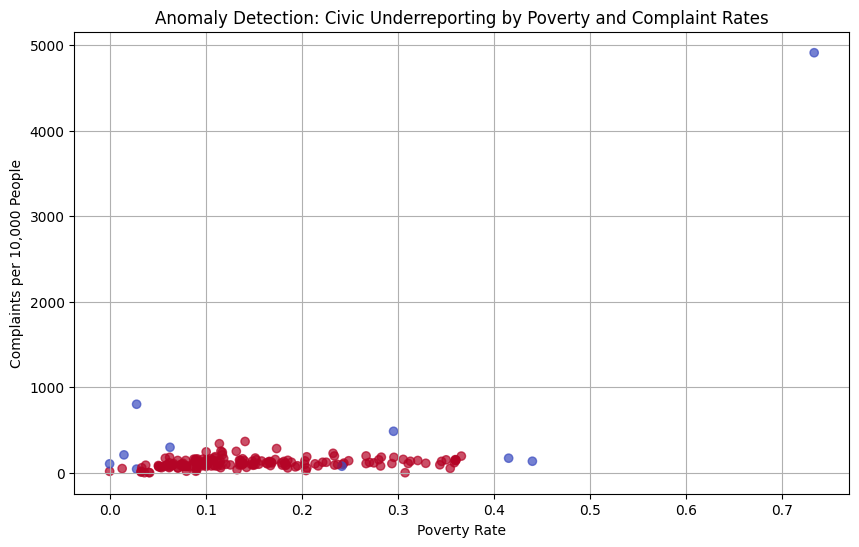

In [28]:
# we will examine how much people report, how economically stressed 
# the area is, and how many people are affected. 

features = ['complaints_per_10k', 'poverty_rate', 'median_income', 'total_population']
X = merged_df[features].dropna()

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(X_scaled)

merged_ml = merged_df.loc[X.index].copy()

# Predict anomaly labels (-1 = anomaly, 1 = normal) and scores
merged_ml['anomaly'] = iso_forest.predict(X_scaled)  
merged_ml['anomaly_score'] = iso_forest.decision_function(X_scaled)

plt.figure(figsize=(10,6))
plt.scatter(merged_ml['poverty_rate'], merged_ml['complaints_per_10k'], 
            c=merged_ml['anomaly'], cmap='coolwarm', alpha=0.7)
plt.xlabel('Poverty Rate')
plt.ylabel('Complaints per 10,000 People')
plt.title('Anomaly Detection: Civic Underreporting by Poverty and Complaint Rates')
plt.grid(True)
plt.show()

In [29]:
print(merged_ml[['incident_zip', 'anomaly', 'anomaly_score']].head())

   incident_zip  anomaly  anomaly_score
1         10001        1       0.110352
2         10002        1       0.103166
3         10003        1       0.119661
4         10004       -1      -0.142937
5         10005        1       0.068830


Plot 1: 

When an anomaly = 1, the model thinks that the zip code does not follow a general pattern, in this case, the zip code is not an underreporter. The higher the anomaly score, the more normal the zip code is. When an anomaly = -1, the model think that the zip code is an anomaly, meaning that it is likely that there is underreporting. The lower the anomaly score, the more anbormal the zip code is. 

The zip code 10004 has anomaly = -1 and an anomaly score of -0.142937. This zip code is flagged as an anomaly as it likely has suspiciously low complaints compared to its poverty rate, income, and population.

In [34]:
# Fix invalid median_income values
merged_ml['median_income'] = merged_ml['median_income'].replace(-666666666.0, np.nan)

# Select only anomalies (potential underreporters)
underreporting_zips = merged_ml[merged_ml['anomaly'] == -1]

# Sort by anomaly_score ascending (most negative first)
top_underreporters = underreporting_zips.sort_values('anomaly_score').head(10)

print(top_underreporters[['incident_zip', 'borough', 'complaints_per_10k', 'poverty_rate', 'median_income', 'anomaly_score']])

     incident_zip    borough  complaints_per_10k  poverty_rate  median_income  \
201         11430     QUEENS         4909.090909      0.733645            NaN   
68          10279  MANHATTAN          104.166667      0.000000            NaN   
4           10004  MANHATTAN          800.604230      0.028097       204949.0   
156         11239   BROOKLYN          484.725686      0.295652        29571.0   
107         10474      BRONX          170.135590      0.415486        28419.0   
87          10454      BRONX          134.631153      0.440202        23337.0   
7           10007  MANHATTAN          208.828972      0.014939       250001.0   
71          10282  MANHATTAN           42.720999      0.028097       250001.0   
129         11211   BROOKLYN           76.319086      0.241859        90871.0   
6           10006  MANHATTAN          297.546012      0.062883       185268.0   

     anomaly_score  
201      -0.337773  
68       -0.241985  
4        -0.142937  
156      -0.074403  
107

Using the Isolation Forest model, we identified the top 10 zip codes with unusually low complaint rates given their demographics. These neighborhoods exhibited significantly lower civic reporting activity despite high poverty rates and large populations, suggesting potential underreporting issues.

Based on the outcomes using an isloation forest model, Zip codes with bad income data were flagged likely because of missing Census data. Zip codes with very low complaints per 10k people even when poverty rates are moderate/high were flagged as well. Even wealthy zip codes with low poverty but low complaints. 

Additional Quality Check: 

During the analysis, we observed invalid median income values (-666,666,666) for a small number of zip codes. These were treated as missing values, as they likely arose from unmatched records during dataset merging.

In [35]:
# Only show anomalies where median income is not missing
underreporting_zips = merged_ml[(merged_ml['anomaly'] == -1) & (merged_ml['median_income'].notnull())]

top_underreporters = underreporting_zips.sort_values('anomaly_score').head(10)

print(top_underreporters[['incident_zip', 'borough', 'complaints_per_10k', 'poverty_rate', 'median_income', 'anomaly_score']])

     incident_zip    borough  complaints_per_10k  poverty_rate  median_income  \
4           10004  MANHATTAN          800.604230      0.028097       204949.0   
156         11239   BROOKLYN          484.725686      0.295652        29571.0   
107         10474      BRONX          170.135590      0.415486        28419.0   
87          10454      BRONX          134.631153      0.440202        23337.0   
7           10007  MANHATTAN          208.828972      0.014939       250001.0   
71          10282  MANHATTAN           42.720999      0.028097       250001.0   
129         11211   BROOKLYN           76.319086      0.241859        90871.0   
6           10006  MANHATTAN          297.546012      0.062883       185268.0   

     anomaly_score  
4        -0.142937  
156      -0.074403  
107      -0.054627  
87       -0.043674  
7        -0.029444  
71       -0.024345  
129      -0.023634  
6        -0.000669  


After showing anamolies with non missing data: 

Bronx zips (10474, 10454) have high poverty but low complaints, which likely suggests civic underreporting. Brooklyn zip (11211) has moderate poverty but low complaints, suggesting possible underreporting, and Manhattan zips (10282) have low poverty and very low complaints, which could be less critical, but still an interesting anomaly. 

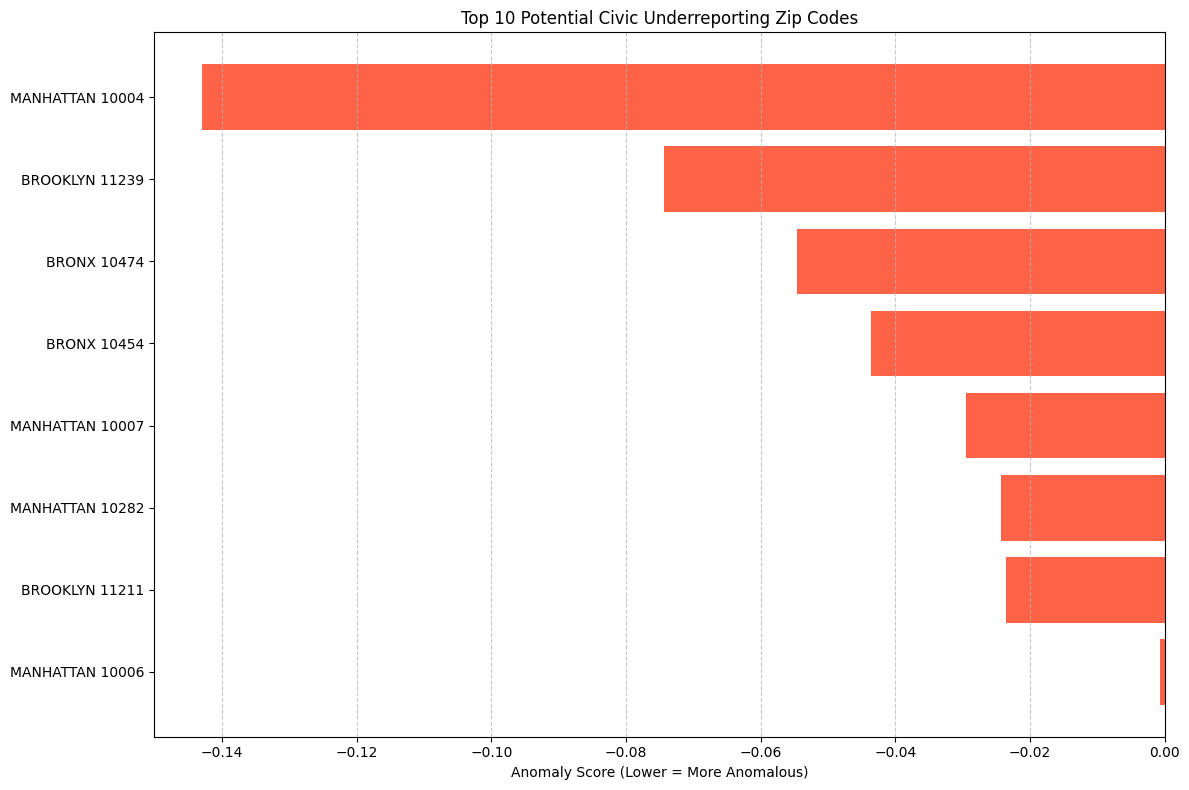

In [37]:
# viewing top civic underreporting
top_underreporters['label'] = top_underreporters['borough'] + " " + top_underreporters['incident_zip'].astype(str)

# Sort so that the most abnormal is at the top of the bar chart
top_underreporters = top_underreporters.sort_values('anomaly_score')


plt.figure(figsize=(12,8))
plt.barh(top_underreporters['label'], top_underreporters['anomaly_score'], color='tomato')
plt.xlabel('Anomaly Score (Lower = More Anomalous)')
plt.title('Top 10 Potential Civic Underreporting Zip Codes')
plt.gca().invert_yaxis()  # Highest anomaly (most negative score) at top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Note: Manhattan 10004 is located in the Financial District, so it is mostly non residential. On the contrary, Brooklyn 11239 is the Spring Creek Neighborhood, with a median household income of $26,275, which supports claims for underreporting in lower income communities. 